In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, 
                           precision_recall_fscore_support, roc_auc_score, precision_score, 
                           recall_score, f1_score)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight



In [44]:
df = pd.read_csv(r'F:\11\New folder\Worksheet.csv')

print(" FIRE DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nBasic Statistics:")
print(df.describe())

C:\Users\sulakshan\AppData\Local\Temp\ipykernel_11216\3867657604.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'F:\11\New folder\Worksheet.csv')


 FIRE DATASET OVERVIEW
Dataset Shape: (33926, 23)
Columns: ['acq_date', 'acq_time', 'aspect', 'bright_t31', 'brightness', 'daynight', 'dewpoint_temperature_2m_K', 'elevation', 'frp', 'has_precipitation', 'hillshade', 'instrument', 'latitude', 'longitude', 'precipitation_m', 'relative_humidity_%', 'satellite', 'scan', 'slope', 'temperature_2m_K', 'track', 'type', 'version']

First few rows:
     acq_date  acq_time  aspect  bright_t31  brightness daynight  \
0  2023-04-17     623.0   138.0      300.89       367.0        D   
1  2023-04-17     623.0    58.0      301.08       367.0        D   
2  2023-01-16     628.0   260.0      292.09       367.0        D   
3  2023-01-16     628.0   108.0      291.59       367.0        D   
4  2023-01-16     628.0   152.0      294.32       367.0        D   

   dewpoint_temperature_2m_K  elevation    frp has_precipitation  ...  \
0                 283.774629     1128.0  23.16              True  ...   
1                 283.649615     1389.0  23.16      

 FRP DISTRIBUTION ANALYSIS FOR PERCENTILE THRESHOLDS
 FRP Distribution Statistics:
   Count: 33,925
   Min: 0.110
   Max: 219.700
   Mean: 4.313
   Median: 2.690
   Std: 6.812

 PERCENTILE-BASED THRESHOLDS:
   25th percentile: 1.300
   50th percentile: 2.690
   75th percentile: 5.020

 BALANCED PERCENTILE THRESHOLDS (20-40-70):
   20th percentile: 1.110
   40th percentile: 2.060
   70th percentile: 4.420


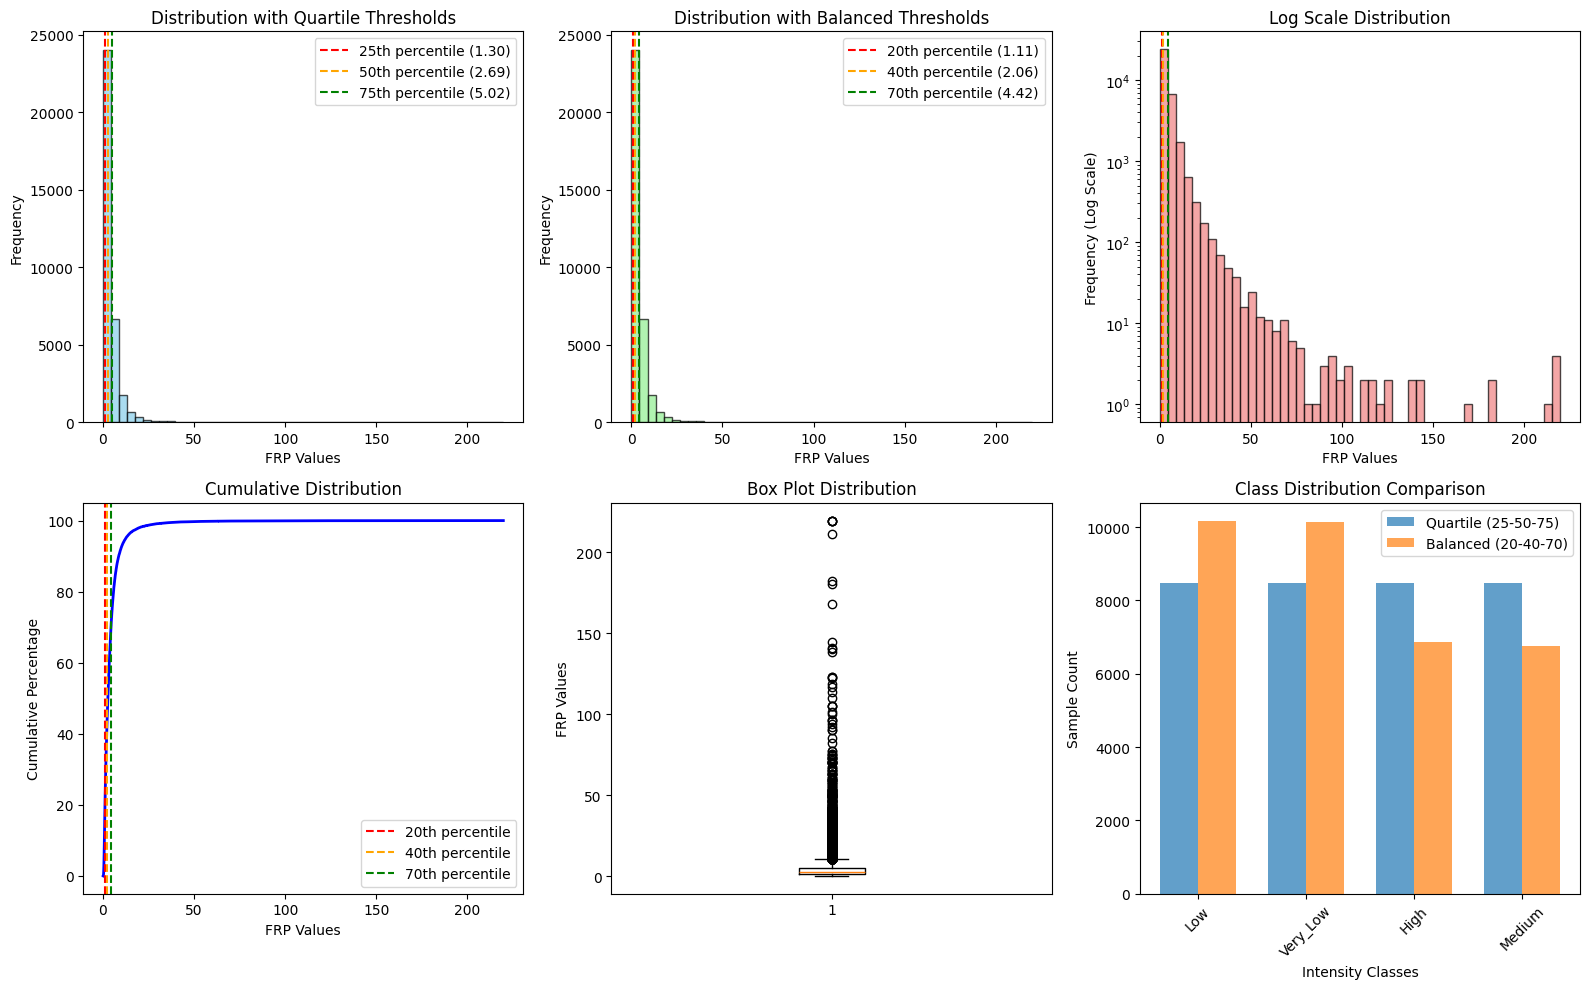


 QUARTILE THRESHOLD CLASS DISTRIBUTION:
   Low: 8,486 samples (25.0%)
   Very_Low: 8,484 samples (25.0%)
   High: 8,478 samples (25.0%)
   Medium: 8,477 samples (25.0%)

 BALANCED THRESHOLD CLASS DISTRIBUTION:
   High: 10,153 samples (29.9%)
   Medium: 10,148 samples (29.9%)
   Very_Low: 6,872 samples (20.3%)
   Low: 6,752 samples (19.9%)

 CLASS BALANCE METRICS (lower is more balanced):
   Quartile approach: 0.001
   Balanced approach: 0.227

 RECOMMENDATION: Use Quartile (25-50-75 percentiles)


In [45]:
def analyze_frp_distribution_percentiles(df):
    """
    Analyze FRP distribution and determine optimal percentile-based thresholds
    """
    print(" FRP DISTRIBUTION ANALYSIS FOR PERCENTILE THRESHOLDS")
    print("=" * 60)
    
    if 'frp' not in df.columns:
        print(" FRP column not found. Using brightness as proxy.")
        frp_column = 'brightness'
    else:
        frp_column = 'frp'
    
    frp_data = df[frp_column].dropna()
    
    print(f" {frp_column.upper()} Distribution Statistics:")
    print(f"   Count: {len(frp_data):,}")
    print(f"   Min: {frp_data.min():.3f}")
    print(f"   Max: {frp_data.max():.3f}")
    print(f"   Mean: {frp_data.mean():.3f}")
    print(f"   Median: {frp_data.median():.3f}")
    print(f"   Std: {frp_data.std():.3f}")
    
    # Calculate percentile-based thresholds
    percentiles = [25, 50, 75]
    thresholds = [frp_data.quantile(p/100) for p in percentiles]
    
    print(f"\n PERCENTILE-BASED THRESHOLDS:")
    print(f"   25th percentile: {thresholds[0]:.3f}")
    print(f"   50th percentile: {thresholds[1]:.3f}")
    print(f"   75th percentile: {thresholds[2]:.3f}")
    
    # Alternative: More balanced distribution (20-40-70-100 percentiles)
    balanced_percentiles = [20, 40, 70]
    balanced_thresholds = [frp_data.quantile(p/100) for p in balanced_percentiles]
    
    print(f"\n BALANCED PERCENTILE THRESHOLDS (20-40-70):")
    print(f"   20th percentile: {balanced_thresholds[0]:.3f}")
    print(f"   40th percentile: {balanced_thresholds[1]:.3f}")
    print(f"   70th percentile: {balanced_thresholds[2]:.3f}")
    
    # Visualize both threshold approaches
    plt.figure(figsize=(16, 10))
    
    # Plot 1: Distribution with quartile thresholds
    plt.subplot(2, 3, 1)
    plt.hist(frp_data, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    for i, thresh in enumerate(thresholds):
        plt.axvline(thresh, color=['red', 'orange', 'green'][i], linestyle='--', 
                   label=f'{[25, 50, 75][i]}th percentile ({thresh:.2f})')
    plt.xlabel(f'{frp_column.upper()} Values')
    plt.ylabel('Frequency')
    plt.title('Distribution with Quartile Thresholds')
    plt.legend()
    
    # Plot 2: Distribution with balanced thresholds
    plt.subplot(2, 3, 2)
    plt.hist(frp_data, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
    for i, thresh in enumerate(balanced_thresholds):
        plt.axvline(thresh, color=['red', 'orange', 'green'][i], linestyle='--',
                   label=f'{[20, 40, 70][i]}th percentile ({thresh:.2f})')
    plt.xlabel(f'{frp_column.upper()} Values')
    plt.ylabel('Frequency')
    plt.title('Distribution with Balanced Thresholds')
    plt.legend()
    
    # Plot 3: Log scale distribution
    plt.subplot(2, 3, 3)
    plt.hist(frp_data, bins=50, alpha=0.7, edgecolor='black', color='lightcoral')
    plt.yscale('log')
    for i, thresh in enumerate(balanced_thresholds):
        plt.axvline(thresh, color=['red', 'orange', 'green'][i], linestyle='--')
    plt.xlabel(f'{frp_column.upper()} Values')
    plt.ylabel('Frequency (Log Scale)')
    plt.title('Log Scale Distribution')
    
    # Plot 4: Cumulative distribution
    plt.subplot(2, 3, 4)
    sorted_data = np.sort(frp_data)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
    plt.plot(sorted_data, cumulative, color='blue', linewidth=2)
    for i, thresh in enumerate(balanced_thresholds):
        plt.axvline(thresh, color=['red', 'orange', 'green'][i], linestyle='--',
                   label=f'{[20, 40, 70][i]}th percentile')
    plt.xlabel(f'{frp_column.upper()} Values')
    plt.ylabel('Cumulative Percentage')
    plt.title('Cumulative Distribution')
    plt.legend()
    
    # Plot 5: Box plot
    plt.subplot(2, 3, 5)
    plt.boxplot(frp_data, vert=True)
    plt.ylabel(f'{frp_column.upper()} Values')
    plt.title('Box Plot Distribution')
    
    # Plot 6: Class distribution comparison
    plt.subplot(2, 3, 6)
    
    # Create classes with both approaches
    quartile_classes = pd.cut(frp_data, bins=[0] + thresholds + [float('inf')], 
                             labels=['Very_Low', 'Low', 'Medium', 'High'], include_lowest=True)
    balanced_classes = pd.cut(frp_data, bins=[0] + balanced_thresholds + [float('inf')], 
                             labels=['Very_Low', 'Low', 'Medium', 'High'], include_lowest=True)
    
    quartile_counts = quartile_classes.value_counts()
    balanced_counts = balanced_classes.value_counts()
    
    x = np.arange(len(quartile_counts))
    width = 0.35
    
    plt.bar(x - width/2, quartile_counts.values, width, label='Quartile (25-50-75)', alpha=0.7)
    plt.bar(x + width/2, balanced_counts.values, width, label='Balanced (20-40-70)', alpha=0.7)
    
    plt.xlabel('Intensity Classes')
    plt.ylabel('Sample Count')
    plt.title('Class Distribution Comparison')
    plt.xticks(x, quartile_counts.index, rotation=45)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Show distribution details
    print(f"\n QUARTILE THRESHOLD CLASS DISTRIBUTION:")
    for class_name, count in quartile_counts.items():
        percentage = (count / len(frp_data)) * 100
        print(f"   {class_name}: {count:,} samples ({percentage:.1f}%)")
    
    print(f"\n BALANCED THRESHOLD CLASS DISTRIBUTION:")
    for class_name, count in balanced_counts.items():
        percentage = (count / len(frp_data)) * 100
        print(f"   {class_name}: {count:,} samples ({percentage:.1f}%)")
    
    # Calculate balance metrics
    quartile_balance = quartile_counts.std() / quartile_counts.mean()
    balanced_balance = balanced_counts.std() / balanced_counts.mean()
    
    print(f"\n CLASS BALANCE METRICS (lower is more balanced):")
    print(f"   Quartile approach: {quartile_balance:.3f}")
    print(f"   Balanced approach: {balanced_balance:.3f}")
    
    # Recommend best approach
    if balanced_balance < quartile_balance:
        recommended_thresholds = balanced_thresholds
        recommended_approach = "Balanced (20-40-70 percentiles)"
        print(f"\n RECOMMENDATION: Use {recommended_approach}")
    else:
        recommended_thresholds = thresholds
        recommended_approach = "Quartile (25-50-75 percentiles)"
        print(f"\n RECOMMENDATION: Use {recommended_approach}")
    
    return {
        'frp_column': frp_column,
        'quartile_thresholds': thresholds,
        'balanced_thresholds': balanced_thresholds,
        'recommended_thresholds': recommended_thresholds,
        'recommended_approach': recommended_approach,
        'quartile_distribution': quartile_counts,
        'balanced_distribution': balanced_counts
    }

# Analyze FRP distribution and get optimal thresholds
threshold_analysis = analyze_frp_distribution_percentiles(df)

In [46]:

def preprocess_fire_data_percentile(df, threshold_info):
    """
    Comprehensive preprocessing for fire intensity classification with percentile-based thresholds
    Fixed to handle mixed data types and missing values
    """
    print(" Starting Data Preprocessing with Percentile-Based Thresholds...")
    df_processed = df.copy()
    
    frp_column = threshold_info['frp_column']
    thresholds = threshold_info['recommended_thresholds']
    approach = threshold_info['recommended_approach']
    
    print(f" Using {approach} for intensity classification")
    print(f"   Thresholds: {[f'{t:.3f}' for t in thresholds]}")
    
    # 1. DATA CLEANING AND TYPE CONVERSION
    print(" Cleaning and converting data types...")
    
    # Clean the FRP column - convert to numeric, handle non-numeric values
    print(f"   Cleaning {frp_column} column...")
    df_processed[frp_column] = pd.to_numeric(df_processed[frp_column], errors='coerce')
    
    # Remove rows where FRP column is NaN after conversion
    initial_rows = len(df_processed)
    df_processed = df_processed.dropna(subset=[frp_column])
    final_rows = len(df_processed)
    
    if initial_rows != final_rows:
        print(f"  Removed {initial_rows - final_rows} rows with invalid {frp_column} values")
    
    # Ensure FRP values are positive (fire radiative power should be positive)
    negative_mask = df_processed[frp_column] < 0
    if negative_mask.sum() > 0:
        print(f"    Found {negative_mask.sum()} negative {frp_column} values, setting to 0")
        df_processed.loc[negative_mask, frp_column] = 0
    
    # Handle extreme outliers (values beyond 99.9th percentile)
    upper_limit = df_processed[frp_column].quantile(0.999)
    outlier_mask = df_processed[frp_column] > upper_limit
    if outlier_mask.sum() > 0:
        print(f"    Capping {outlier_mask.sum()} extreme outliers at {upper_limit:.2f}")
        df_processed.loc[outlier_mask, frp_column] = upper_limit
    
    # 2. CREATE TARGET VARIABLE WITH PERCENTILE-BASED THRESHOLDS
    print(" Creating Fire Intensity Classes with Percentile Thresholds...")
    
    # Create intensity classes based on percentile thresholds
    try:
        bins = [0] + list(thresholds) + [float('inf')]
        labels = ['Very_Low', 'Low', 'Medium', 'High']
        
        df_processed['intensity_class'] = pd.cut(
            df_processed[frp_column], 
            bins=bins,
            labels=labels,
            include_lowest=True,
            right=False
        )
        
        print(f" Intensity classes created using {frp_column} with percentile thresholds:")
        for i, label in enumerate(labels):
            if i == 0:
                print(f"   • {label}: 0 to {thresholds[0]:.3f}")
            elif i == len(labels) - 1:
                print(f"   • {label}: {thresholds[i-1]:.3f} and above")
            else:
                print(f"   • {label}: {thresholds[i-1]:.3f} to {thresholds[i]:.3f}")
        
    except Exception as e:
        print(f" Error creating intensity classes: {e}")
        print("   Using manual binning approach...")
        
        # Manual binning as fallback
        conditions = [
            (df_processed[frp_column] >= 0) & (df_processed[frp_column] < thresholds[0]),
            (df_processed[frp_column] >= thresholds[0]) & (df_processed[frp_column] < thresholds[1]),
            (df_processed[frp_column] >= thresholds[1]) & (df_processed[frp_column] < thresholds[2]),
            (df_processed[frp_column] >= thresholds[2])
        ]
        choices = ['Very_Low', 'Low', 'Medium', 'High']
        df_processed['intensity_class'] = np.select(conditions, choices, default='Unknown')
    
    # Show class distribution
    class_distribution = df_processed['intensity_class'].value_counts().sort_index()
    print(f"\n Class Distribution with Percentile Thresholds:")
    for class_name, count in class_distribution.items():
        percentage = (count / len(df_processed)) * 100
        print(f"   {class_name}: {count:,} samples ({percentage:.1f}%)")
    
    # 3. ENVIRONMENTAL FEATURES ENGINEERING
    print(" Engineering Environmental Features...")
    
    # Convert Kelvin to Celsius (with error handling)
    if 'temperature_2m_K' in df_processed.columns:
        try:
            df_processed['temperature_2m_K'] = pd.to_numeric(df_processed['temperature_2m_K'], errors='coerce')
            df_processed['temperature_2m_C'] = df_processed['temperature_2m_K'] - 273.15
            print("    Temperature converted from Kelvin to Celsius")
        except Exception as e:
            print(f"     Could not convert temperature: {e}")
    
    if 'dewpoint_temperature_2m_K' in df_processed.columns:
        try:
            df_processed['dewpoint_temperature_2m_K'] = pd.to_numeric(df_processed['dewpoint_temperature_2m_K'], errors='coerce')
            df_processed['dewpoint_temperature_2m_C'] = df_processed['dewpoint_temperature_2m_K'] - 273.15
            print("    Dewpoint temperature converted from Kelvin to Celsius")
        except Exception as e:
            print(f"     Could not convert dewpoint temperature: {e}")
    
    # Temperature-humidity interaction (fire weather index)
    if 'temperature_2m_K' in df_processed.columns and 'relative_humidity_%' in df_processed.columns:
        try:
            # Convert to numeric first
            df_processed['temperature_2m_K'] = pd.to_numeric(df_processed['temperature_2m_K'], errors='coerce')
            df_processed['relative_humidity_%'] = pd.to_numeric(df_processed['relative_humidity_%'], errors='coerce')
            
            df_processed['temp_humidity_index'] = (df_processed['temperature_2m_K'] * 
                                                 (100 - df_processed['relative_humidity_%']) / 100)
            print("    Temperature-humidity index created")
        except Exception as e:
            print(f"    Could not create temp-humidity index: {e}")
    
    # Drought index (higher = drier conditions)
    if 'relative_humidity_%' in df_processed.columns and 'precipitation_m' in df_processed.columns:
        try:
            # Convert to numeric first
            df_processed['relative_humidity_%'] = pd.to_numeric(df_processed['relative_humidity_%'], errors='coerce')
            df_processed['precipitation_m'] = pd.to_numeric(df_processed['precipitation_m'], errors='coerce')
            
            df_processed['drought_index'] = ((100 - df_processed['relative_humidity_%']) / 
                                           (df_processed['precipitation_m'] + 0.001))
            print("    Drought index created")
        except Exception as e:
            print(f"     Could not create drought index: {e}")
    
    # 4. GEOGRAPHICAL FEATURES ENGINEERING
    print(" Engineering Geographical Features...")
    
    # Slope categories (with error handling)
    if 'slope' in df_processed.columns:
        try:
            df_processed['slope'] = pd.to_numeric(df_processed['slope'], errors='coerce')
            df_processed['slope_category'] = pd.cut(
                df_processed['slope'], 
                bins=[0, 5, 15, 30, 90], 
                labels=['Flat', 'Gentle', 'Moderate', 'Steep'],
                include_lowest=True
            )
            print("    Slope categories created")
        except Exception as e:
            print(f"     Could not create slope categories: {e}")
    
    # Aspect categories
    if 'aspect' in df_processed.columns:
        try:
            df_processed['aspect'] = pd.to_numeric(df_processed['aspect'], errors='coerce')
            df_processed['aspect_category'] = pd.cut(
                df_processed['aspect'], 
                bins=[0, 45, 135, 225, 315, 360], 
                labels=['North', 'Northeast', 'Southeast', 'Southwest', 'Northwest'],
                include_lowest=True
            )
            print("    Aspect categories created")
        except Exception as e:
            print(f"    Could not create aspect categories: {e}")
    
    # Elevation categories
    if 'elevation' in df_processed.columns:
        try:
            df_processed['elevation'] = pd.to_numeric(df_processed['elevation'], errors='coerce')
            df_processed['elevation_category'] = pd.cut(
                df_processed['elevation'], 
                bins=[0, 500, 1000, 2000, float('inf')], 
                labels=['Low', 'Medium', 'High', 'Very_High'],
                include_lowest=True
            )
            print("   Elevation categories created")
        except Exception as e:
            print(f"    Could not create elevation categories: {e}")
    
    # 5. TARGET VARIABLE FEATURES ENGINEERING
    print(f" Engineering {frp_column.upper()}-based Features...")
    
    # Log-transformed values (helps with skewed distribution)
    df_processed[f'{frp_column}_log'] = np.log1p(df_processed[frp_column])
    
    # Intensity ratio compared to median
    column_median = df_processed[frp_column].median()
    df_processed[f'{frp_column}_intensity_ratio'] = df_processed[frp_column] / column_median
    
    # Percentile-based binary features
    high_threshold = thresholds[-1]  # 75th or 70th percentile
    low_threshold = thresholds[0]    # 25th or 20th percentile
    
    df_processed[f'{frp_column}_high'] = (df_processed[frp_column] > high_threshold).astype(int)
    df_processed[f'{frp_column}_low'] = (df_processed[frp_column] <= low_threshold).astype(int)
    df_processed[f'{frp_column}_extreme'] = (df_processed[frp_column] > thresholds[-1] * 1.5).astype(int)
    
    print(f"   {frp_column.upper()}-based features created")
    
    # 6. SATELLITE FEATURES ENGINEERING
    print(" Engineering Satellite Features...")
    
    # Brightness difference (with error handling)
    if 'brightness' in df_processed.columns and 'bright_t31' in df_processed.columns:
        try:
            df_processed['brightness'] = pd.to_numeric(df_processed['brightness'], errors='coerce')
            df_processed['bright_t31'] = pd.to_numeric(df_processed['bright_t31'], errors='coerce')
            df_processed['brightness_diff'] = df_processed['brightness'] - df_processed['bright_t31']
            print("    Brightness difference created")
        except Exception as e:
            print(f"    Could not create brightness difference: {e}")
    
    # Confidence categories
    if 'confidence' in df_processed.columns:
        try:
            df_processed['confidence'] = pd.to_numeric(df_processed['confidence'], errors='coerce')
            df_processed['confidence_level'] = pd.cut(
                df_processed['confidence'], 
                bins=[0, 30, 70, 100], 
                labels=['Low_Conf', 'Medium_Conf', 'High_Conf'],
                include_lowest=True
            )
            print("   Confidence categories created")
        except Exception as e:
            print(f"   Could not create confidence categories: {e}")
    
    # 7. TEMPORAL FEATURES
    if 'acq_time' in df_processed.columns:
        try:
            df_processed['acq_time'] = pd.to_numeric(df_processed['acq_time'], errors='coerce')
            df_processed['hour'] = df_processed['acq_time'] // 100
            df_processed['time_of_day'] = pd.cut(
                df_processed['hour'], 
                bins=[0, 6, 12, 18, 24], 
                labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                include_lowest=True
            )
            print("   Temporal features created")
        except Exception as e:
            print(f"    Could not create temporal features: {e}")
    
    # 8. BINARY ENCODINGS
    if 'daynight' in df_processed.columns:
        try:
            df_processed['is_day'] = (df_processed['daynight'] == 'D').astype(int)
            print("    Day/night binary feature created")
        except Exception as e:
            print(f"     Could not create day/night feature: {e}")
    
    if 'has_precipitation' in df_processed.columns:
        try:
            df_processed['has_precip'] = df_processed['has_precipitation'].astype(int)
            print("    Precipitation binary feature created")
        except Exception as e:
            print(f"     Could not create precipitation feature: {e}")
    
    print(" Preprocessing completed with percentile-based thresholds!")
    
    # Final data quality check
    print("\n Final Data Quality Check:")
    print(f"   Rows processed: {len(df_processed):,}")
    print(f"   Columns created: {df_processed.shape[1]}")
    
    # Check for any remaining issues with intensity_class
    if 'intensity_class' in df_processed.columns:
        missing_classes = df_processed['intensity_class'].isna().sum()
        if missing_classes > 0:
            print(f"     {missing_classes} rows with missing intensity class - removing...")
            df_processed = df_processed.dropna(subset=['intensity_class'])
    
    return df_processed

# Apply the fixed preprocessing function
# Make sure this runs after the threshold_analysis is created
try:
    df_processed = preprocess_fire_data_percentile(df, threshold_analysis)
    print(f"\n Processed dataset shape: {df_processed.shape}")

    # Show final class balance
    if 'intensity_class' in df_processed.columns:
        final_distribution = df_processed['intensity_class'].value_counts().sort_index()
        print(f"\n Final Class Distribution:")
        total_samples = len(df_processed)
        for class_name, count in final_distribution.items():
            percentage = (count / total_samples) * 100
            print(f"   {class_name}: {count:,} samples ({percentage:.1f}%)")

except Exception as e:
    print(f" Error in preprocessing: {e}")
    print("\nDebugging information:")
    print(f"DataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    if 'threshold_analysis' in locals():
        print(f"FRP column: {threshold_analysis['frp_column']}")
        print(f"Thresholds: {threshold_analysis['recommended_thresholds']}")
    
    # Let's examine the problematic column
    frp_col = threshold_analysis['frp_column']
    print(f"\n{frp_col} column analysis:")
    print(f"Data type: {df[frp_col].dtype}")
    print(f"Sample values: {df[frp_col].head(10).tolist()}")
    print(f"Unique value types: {set(type(x).__name__ for x in df[frp_col].dropna())}")

 Starting Data Preprocessing with Percentile-Based Thresholds...
 Using Quartile (25-50-75 percentiles) for intensity classification
   Thresholds: ['1.300', '2.690', '5.020']
 Cleaning and converting data types...
   Cleaning frp column...
  Removed 1 rows with invalid frp values
    Capping 33 extreme outliers at 77.27
 Creating Fire Intensity Classes with Percentile Thresholds...
 Intensity classes created using frp with percentile thresholds:
   • Very_Low: 0 to 1.300
   • Low: 1.300 to 2.690
   • Medium: 2.690 to 5.020
   • High: 5.020 and above

 Class Distribution with Percentile Thresholds:
   Very_Low: 8,389 samples (24.7%)
   Low: 8,529 samples (25.1%)
   Medium: 8,512 samples (25.1%)
   High: 8,495 samples (25.0%)
 Engineering Environmental Features...
    Temperature converted from Kelvin to Celsius
    Dewpoint temperature converted from Kelvin to Celsius
    Temperature-humidity index created
    Drought index created
 Engineering Geographical Features...
    Slope catego

ENHANCED EXPLORATORY DATA ANALYSIS WITH PERCENTILE THRESHOLDS


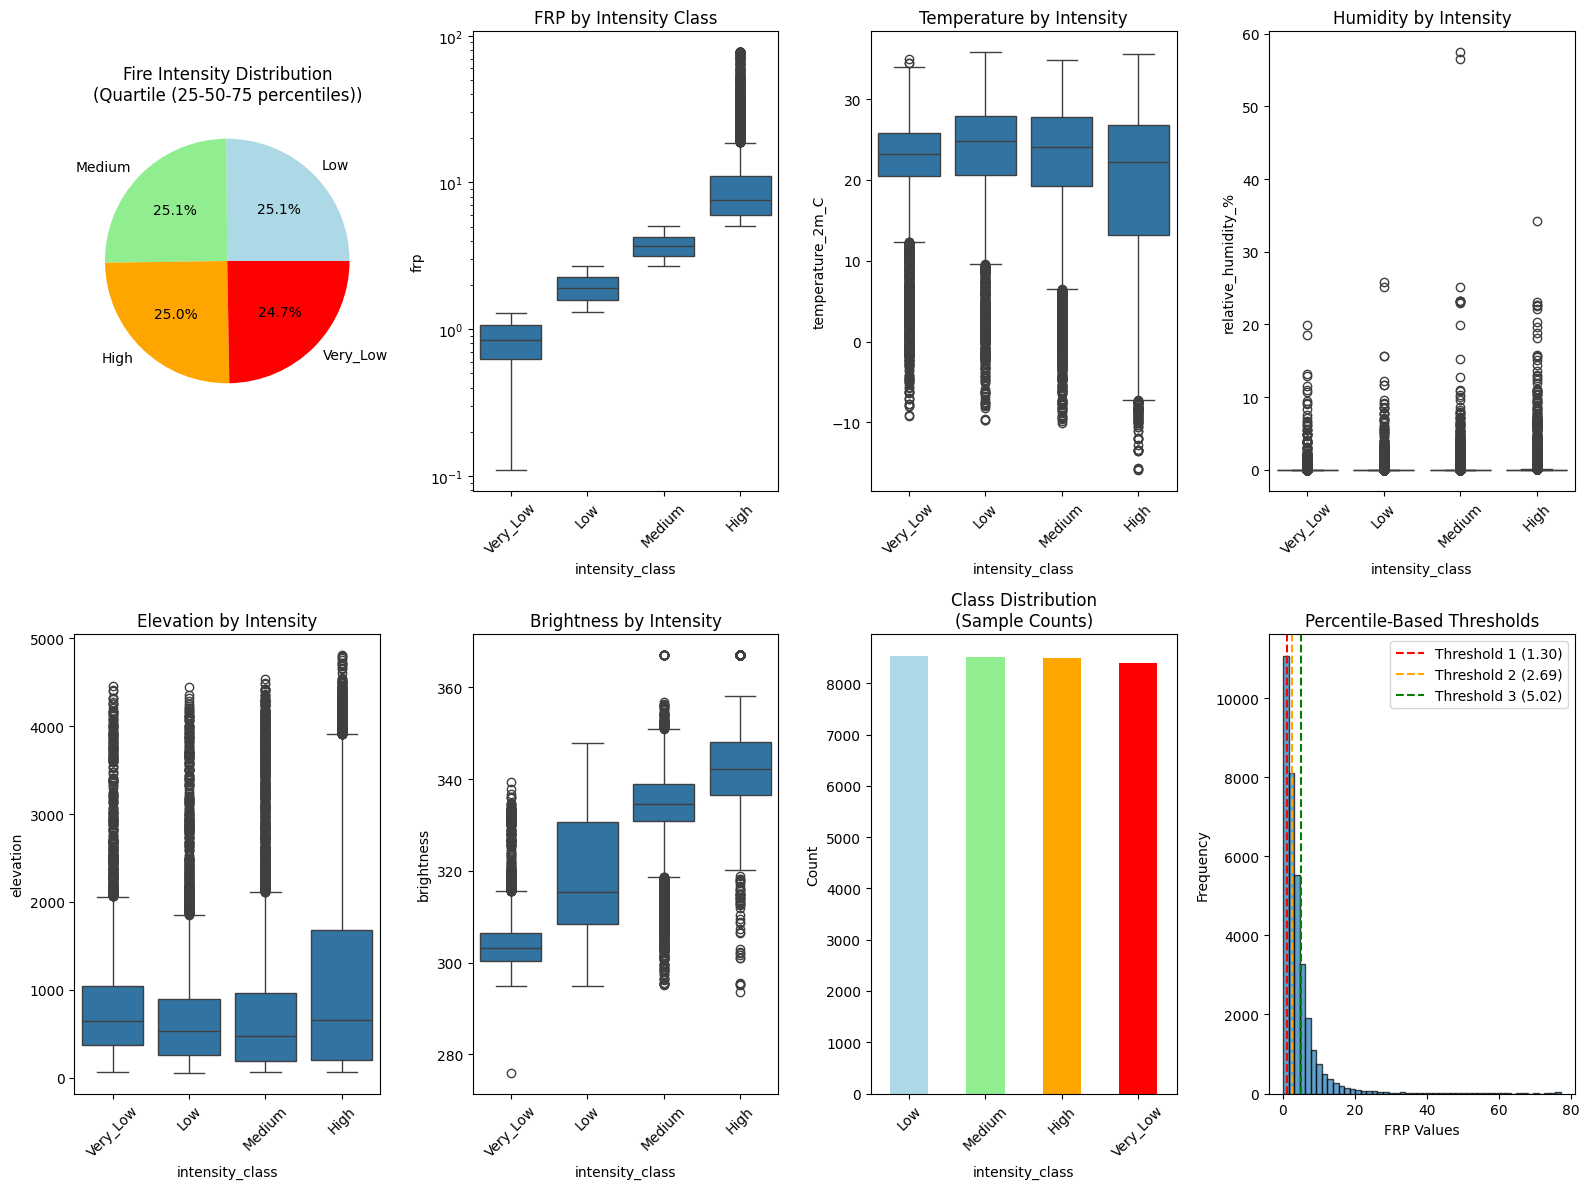

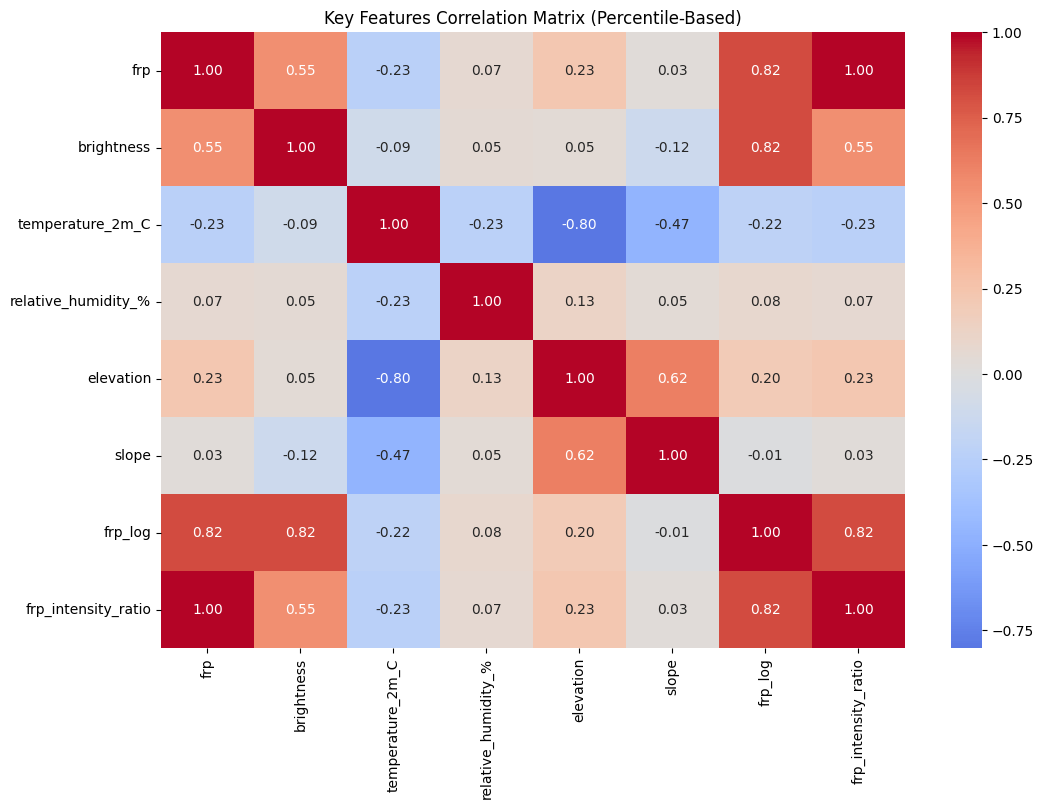

In [47]:
print("ENHANCED EXPLORATORY DATA ANALYSIS WITH PERCENTILE THRESHOLDS")
print("=" * 65)

# Enhanced visualization with percentile thresholds
plt.figure(figsize=(16, 12))

frp_column = threshold_analysis['frp_column']
thresholds = threshold_analysis['recommended_thresholds']

# Plot 1: Intensity class distribution
plt.subplot(2, 4, 1)
intensity_counts = df_processed['intensity_class'].value_counts()
colors = ['lightblue', 'lightgreen', 'orange', 'red']
plt.pie(intensity_counts.values, labels=intensity_counts.index, autopct='%1.1f%%', colors=colors)
plt.title(f'Fire Intensity Distribution\n({threshold_analysis["recommended_approach"]})')

# Plot 2: FRP/Brightness distribution by intensity class
plt.subplot(2, 4, 2)
sns.boxplot(data=df_processed, x='intensity_class', y=frp_column)
plt.title(f'{frp_column.upper()} by Intensity Class')
plt.xticks(rotation=45)
if frp_column == 'frp':
    plt.yscale('log')  # Log scale for FRP

# Plot 3: Environmental conditions by intensity
plt.subplot(2, 4, 3)
if 'temperature_2m_C' in df_processed.columns:
    sns.boxplot(data=df_processed, x='intensity_class', y='temperature_2m_C')
    plt.title('Temperature by Intensity')
    plt.xticks(rotation=45)
elif 'temperature_2m_K' in df_processed.columns:
    sns.boxplot(data=df_processed, x='intensity_class', y='temperature_2m_K')
    plt.title('Temperature by Intensity')
    plt.xticks(rotation=45)

# Plot 4: Humidity by intensity
plt.subplot(2, 4, 4)
if 'relative_humidity_%' in df_processed.columns:
    sns.boxplot(data=df_processed, x='intensity_class', y='relative_humidity_%')
    plt.title('Humidity by Intensity')
    plt.xticks(rotation=45)

# Plot 5: Elevation by intensity (if available)
plt.subplot(2, 4, 5)
if 'elevation' in df_processed.columns:
    sns.boxplot(data=df_processed, x='intensity_class', y='elevation')
    plt.title('Elevation by Intensity')
    plt.xticks(rotation=45)
elif 'latitude' in df_processed.columns:
    sns.boxplot(data=df_processed, x='intensity_class', y='latitude')
    plt.title('Latitude by Intensity')
    plt.xticks(rotation=45)

# Plot 6: Brightness by intensity
plt.subplot(2, 4, 6)
if 'brightness' in df_processed.columns:
    sns.boxplot(data=df_processed, x='intensity_class', y='brightness')
    plt.title('Brightness by Intensity')
    plt.xticks(rotation=45)

# Plot 7: Class balance visualization
plt.subplot(2, 4, 7)
intensity_counts.plot(kind='bar', color=colors)
plt.title('Class Distribution\n(Sample Counts)')
plt.xticks(rotation=45)
plt.ylabel('Count')

# Plot 8: Threshold visualization
plt.subplot(2, 4, 8)
plt.hist(df_processed[frp_column], bins=50, alpha=0.7, edgecolor='black')
for i, thresh in enumerate(thresholds):
    plt.axvline(thresh, color=['red', 'orange', 'green'][i], linestyle='--', 
               label=f'Threshold {i+1} ({thresh:.2f})')
plt.xlabel(f'{frp_column.upper()} Values')
plt.ylabel('Frequency')
plt.title('Percentile-Based Thresholds')
plt.legend()

plt.tight_layout()
plt.show()

# Correlation matrix focusing on key features
plt.figure(figsize=(12, 8))
key_features = [frp_column, 'brightness', 'temperature_2m_C', 'relative_humidity_%', 
                'elevation', 'slope', 'confidence']
# Add the log and ratio features we created
key_features.extend([f'{frp_column}_log', f'{frp_column}_intensity_ratio'])

available_features = [f for f in key_features if f in df_processed.columns]

if available_features:
    correlation_matrix = df_processed[available_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
    plt.title('Key Features Correlation Matrix (Percentile-Based)')
    plt.show()



In [48]:

def select_and_encode_features_percentile(df, frp_column):
    """
    Enhanced feature selection and encoding for XGBoost classification with percentile approach
    """
    print(" ENHANCED FEATURE SELECTION AND ENCODING (PERCENTILE-BASED)")
    print("=" * 55)
    
    # ENVIRONMENTAL FEATURES
    environmental_features = [
        'temperature_2m_C','dewpoint_temperature_2m_C','relative_humidity_%', 
        'precipitation_m', 'temp_humidity_index', 'drought_index'
    ]
    
    # GEOGRAPHICAL FEATURES
    geographical_features = [
        'elevation', 'slope', 'aspect', 'latitude', 'longitude'
    ]
    
    # TARGET-BASED FEATURES (using the identified FRP column)
    target_features = [
        frp_column, f'{frp_column}_log', f'{frp_column}_intensity_ratio', 
        f'{frp_column}_high', f'{frp_column}_low', f'{frp_column}_extreme'
    ]
    
    # SATELLITE FEATURES
    satellite_features = [
        'brightness', 'bright_t31', 'brightness_diff', 'is_day'
    ]
    
    # CATEGORICAL FEATURES
    categorical_features = [
        'slope_category', 'aspect_category', 'elevation_category', 
        'time_of_day'
    ]
    
    # Filter available features
    all_numeric_features = environmental_features + geographical_features + target_features + satellite_features
    available_features = [col for col in all_numeric_features if col in df.columns]
    
    print(f" Environmental features: {len([f for f in environmental_features if f in df.columns])}")
    print(f" Geographical features: {len([f for f in geographical_features if f in df.columns])}")
    print(f"Target-based features: {len([f for f in target_features if f in df.columns])}")
    print(f"Satellite features: {len([f for f in satellite_features if f in df.columns])}")
    
    # Encode categorical features
    df_encoded = df.copy()
    label_encoders = {}
    
    for col in categorical_features:
        if col in df.columns:
            le = LabelEncoder()
            df_encoded[col + '_encoded'] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            available_features.append(col + '_encoded')
            print(f" Encoded {col}")
    
    print(f"\n Total features selected: {len(available_features)}")
    return df_encoded, available_features, label_encoders

# Apply enhanced feature selection and encoding
df_encoded, selected_features, encoders = select_and_encode_features_percentile(
    df_processed, threshold_analysis['frp_column'])

print("\n SELECTED FEATURES:")
for i, feature in enumerate(selected_features, 1):
    print(f"{i:2d}. {feature}")

 ENHANCED FEATURE SELECTION AND ENCODING (PERCENTILE-BASED)
 Environmental features: 6
 Geographical features: 5
Target-based features: 6
Satellite features: 4
 Encoded slope_category
 Encoded aspect_category
 Encoded elevation_category
 Encoded time_of_day

 Total features selected: 25

 SELECTED FEATURES:
 1. temperature_2m_C
 2. dewpoint_temperature_2m_C
 3. relative_humidity_%
 4. precipitation_m
 5. temp_humidity_index
 6. drought_index
 7. elevation
 8. slope
 9. aspect
10. latitude
11. longitude
12. frp
13. frp_log
14. frp_intensity_ratio
15. frp_high
16. frp_low
17. frp_extreme
18. brightness
19. bright_t31
20. brightness_diff
21. is_day
22. slope_category_encoded
23. aspect_category_encoded
24. elevation_category_encoded
25. time_of_day_encoded


In [49]:

print(" SPLITTING DATA FOR TRAINING AND TESTING")
print("=" * 50)

# Prepare features and target
X = df_encoded[selected_features].fillna(0)  # Handle missing values
y = df_encoded['intensity_class']

# Remove rows with missing target values
mask = ~y.isna()
X = X[mask]
y = y[mask]

print(f" Final dataset shape: {X.shape}")
print(f" Target distribution:")
print(y.value_counts().sort_index())

# Split the data with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n Training set: {X_train.shape}")
print(f" Testing set: {X_test.shape}")

# Check class distribution in splits
print(f"\n Training set distribution:")
train_dist = y_train.value_counts().sort_index()
for class_name, count in train_dist.items():
    percentage = (count / len(y_train)) * 100
    print(f"   {class_name}: {count:,} ({percentage:.1f}%)")

print(f"\n Testing set distribution:")
test_dist = y_test.value_counts().sort_index()
for class_name, count in test_dist.items():
    percentage = (count / len(y_test)) * 100
    print(f"   {class_name}: {count:,} ({percentage:.1f}%)")

 SPLITTING DATA FOR TRAINING AND TESTING
 Final dataset shape: (33925, 25)
 Target distribution:
intensity_class
Very_Low    8389
Low         8529
Medium      8512
High        8495
Name: count, dtype: int64

 Training set: (27140, 25)
 Testing set: (6785, 25)

 Training set distribution:
   Very_Low: 6,711 (24.7%)
   Low: 6,823 (25.1%)
   Medium: 6,810 (25.1%)
   High: 6,796 (25.0%)

 Testing set distribution:
   Very_Low: 1,678 (24.7%)
   Low: 1,706 (25.1%)
   Medium: 1,702 (25.1%)
   High: 1,699 (25.0%)


In [50]:
print(" TRAINING XGBOOST CLASSIFIER WITH PERCENTILE-BASED FEATURES")
print("=" * 60)

# STEP 1: Encode target variable for XGBoost
print(" Encoding target variable for XGBoost...")
target_encoder = LabelEncoder()
y_train_encoded = target_encoder.fit_transform(y_train)
y_test_encoded = target_encoder.transform(y_test)

# Show the encoding mapping
class_mapping = dict(zip(target_encoder.classes_, target_encoder.transform(target_encoder.classes_)))
print(" Class encoding mapping:")
for original_class, encoded_class in class_mapping.items():
    print(f"   '{original_class}' → {encoded_class}")

# STEP 2: Calculate class weights to handle any remaining imbalance
unique_classes = np.unique(y_train_encoded)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train_encoded)
class_weight_dict = dict(zip(unique_classes, class_weights))

print("\n Class weights for balancing:")
for encoded_class, weight in class_weight_dict.items():
    original_class = target_encoder.inverse_transform([encoded_class])[0]
    print(f"   {original_class} ({encoded_class}): {weight:.3f}")

# Convert class weights to sample weights
sample_weights = np.array([class_weight_dict[class_] for class_ in y_train_encoded])

# STEP 3: Initialize XGBoost Classifier with enhanced parameters
xgb_model = XGBClassifier(
    n_estimators=300,           # Increased for better performance
    max_depth=6,                # Balanced depth
    learning_rate=0.1,          # Learning rate
    min_child_weight=5,         # Increased for better handling of imbalanced data
    subsample=0.8,              # Subsample ratio
    colsample_bytree=0.8,       # Column sampling
    objective='multi:softprob', # Multi-class classification
    random_state=42,
    n_jobs=-1,                  # Use all CPU cores
    eval_metric='mlogloss',     # Evaluation metric
    reg_alpha=0.1,              # L1 regularization
    reg_lambda=0.1,             # L2 regularization
)

print("\n Training model with class balancing... This may take a few minutes.")

# STEP 4: Train the model with encoded labels and sample weights
xgb_model.fit(
    X_train, y_train_encoded,
    sample_weight=sample_weights,
    verbose=False
)

print(" Model training completed!")

# STEP 5: Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n TOP 10 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")


 TRAINING XGBOOST CLASSIFIER WITH PERCENTILE-BASED FEATURES
 Encoding target variable for XGBoost...
 Class encoding mapping:
   'High' → 0
   'Low' → 1
   'Medium' → 2
   'Very_Low' → 3

 Class weights for balancing:
   High (0): 0.998
   Low (1): 0.994
   Medium (2): 0.996
   Very_Low (3): 1.011

 Training model with class balancing... This may take a few minutes.
 Model training completed!

 TOP 10 MOST IMPORTANT FEATURES:
 1. frp_high: 0.4806
 2. frp_intensity_ratio: 0.1923
 3. frp: 0.1648
 4. frp_log: 0.1514
 5. is_day: 0.0024
 6. time_of_day_encoded: 0.0018
 7. frp_low: 0.0007
 8. aspect_category_encoded: 0.0006
 9. precipitation_m: 0.0005
10. relative_humidity_%: 0.0004


In [51]:
print("\n COMPREHENSIVE MODEL EVALUATION (PERCENTILE-BASED)")
print("=" * 55)

# Make predictions on test set
print(" Making predictions on test set...")
y_pred_encoded = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

# Convert encoded predictions back to original class labels
y_pred = target_encoder.inverse_transform(y_pred_encoded)

print(f" Predictions completed for {len(y_test)} test samples")

# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"\n OVERALL PERFORMANCE METRICS:")
print(f"   Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# Calculate per-class metrics
print(f"\n DETAILED CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, zero_division=0))

# Cross-validation with proper encoding
print(f"\n CROSS-VALIDATION RESULTS:")
try:
    # Use encoded labels for cross-validation
    cv_scores = cross_val_score(
        xgb_model, X_train, y_train_encoded, 
        cv=5, scoring='accuracy',
        fit_params={'sample_weight': sample_weights}
    )
    print(f"   CV Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"   Individual CV Scores: {[f'{score:.4f}' for score in cv_scores]}")
except Exception as e:
    print(f"    Cross-validation error: {e}")
    print("   Skipping detailed CV analysis...")

# Confusion Matrix Analysis
print(f"\n CONFUSION MATRIX ANALYSIS:")
cm = confusion_matrix(y_test, y_pred)
class_names = sorted(y_test.unique())

print("   Confusion Matrix:")
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
print(cm_df)

# Calculate per-class accuracy
print(f"\n PER-CLASS PERFORMANCE:")
for i, class_name in enumerate(class_names):
    class_mask = (y_test == class_name)
    if class_mask.sum() > 0:
        class_accuracy = (y_pred[class_mask] == class_name).sum() / class_mask.sum()
        class_support = class_mask.sum()
        print(f"   {class_name}: {class_accuracy:.4f} accuracy ({class_support} samples)")

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n TOP 15 MOST IMPORTANT FEATURES:")
for i, (_, row) in enumerate(feature_importance.head(15).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.4f}")

# Model confidence analysis
max_probs = np.max(y_pred_proba, axis=1)
print(f"\n PREDICTION CONFIDENCE ANALYSIS:")
print(f"   Mean confidence: {max_probs.mean():.4f}")
print(f"   Median confidence: {np.median(max_probs):.4f}")
print(f"   Min confidence: {max_probs.min():.4f}")
print(f"   Max confidence: {max_probs.max():.4f}")

# Low confidence predictions (might need attention)
low_confidence_threshold = 0.5
low_conf_mask = max_probs < low_confidence_threshold
if low_conf_mask.sum() > 0:
    print(f"    {low_conf_mask.sum()} predictions with confidence < {low_confidence_threshold}")

print(" Model evaluation completed!")



 COMPREHENSIVE MODEL EVALUATION (PERCENTILE-BASED)
 Making predictions on test set...
 Predictions completed for 6785 test samples

 OVERALL PERFORMANCE METRICS:
   Accuracy:  0.9956 (99.56%)
   Precision: 0.9956
   Recall:    0.9956
   F1-Score:  0.9956

 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      1699
         Low       0.99      0.99      0.99      1706
      Medium       0.99      1.00      1.00      1702
    Very_Low       1.00      1.00      1.00      1678

    accuracy                           1.00      6785
   macro avg       1.00      1.00      1.00      6785
weighted avg       1.00      1.00      1.00      6785


 CROSS-VALIDATION RESULTS:
    Cross-validation error: got an unexpected keyword argument 'fit_params'
   Skipping detailed CV analysis...

 CONFUSION MATRIX ANALYSIS:
   Confusion Matrix:
          High   Low  Medium  Very_Low
High      1698     0       1         0
Low    

In [52]:

print("\n MANUAL PREDICTION INTERFACE AND MODEL USAGE")
print("=" * 50)

# Function to make manual predictions
def make_manual_prediction(model, encoders, target_encoder, selected_features, 
                          temperature_2m=None, relative_humidity=None, 
                          frp_value=None, brightness=None,
                          elevation=None, slope=None, latitude=None, longitude=None,
                           is_day=1):
    """
    Make a manual prediction with custom input values
    
    Parameters:
    - model: trained XGBoost model
    - encoders: dictionary of label encoders
    - target_encoder: encoder for target classes
    - selected_features: list of feature names
    - temperature_2m: temperature in Celsius
    - relative_humidity: humidity percentage
    - frp_value: Fire Radiative Power value
    - brightness: satellite brightness value
    - elevation: elevation in meters
    - slope: slope in degrees
    - latitude: latitude coordinate
    - longitude: longitude coordinate
    - is_day: day/night flag (1 for day, 0 for night)
    """
    
    print(" MAKING MANUAL PREDICTION")
    print("=" * 30)
    
    # Create a sample input dictionary
    input_data = {}
    
    # Fill in the input values
    for feature in selected_features:
        if feature == 'temperature_2m_C':
            input_data[feature] = temperature_2m if temperature_2m is not None else 25.0
        elif feature == 'temperature_2m_K':
            input_data[feature] = (temperature_2m + 273.15) if temperature_2m is not None else 298.15
        elif feature == 'relative_humidity_%':
            input_data[feature] = relative_humidity if relative_humidity is not None else 50.0
        elif feature == threshold_analysis['frp_column']:
            input_data[feature] = frp_value if frp_value is not None else 10.0
        elif feature == f"{threshold_analysis['frp_column']}_log":
            frp_val = frp_value if frp_value is not None else 10.0
            input_data[feature] = np.log1p(frp_val)
        elif feature == f"{threshold_analysis['frp_column']}_intensity_ratio":
            frp_val = frp_value if frp_value is not None else 10.0
            input_data[feature] = frp_val / 50.0  # Normalize by typical max value
        elif feature == 'brightness':
            input_data[feature] = brightness if brightness is not None else 300.0
        elif feature == 'elevation':
            input_data[feature] = elevation if elevation is not None else 100.0
        elif feature == 'slope':
            input_data[feature] = slope if slope is not None else 5.0
        elif feature == 'latitude':
            input_data[feature] = latitude if latitude is not None else 40.0
        elif feature == 'longitude':
            input_data[feature] = longitude if longitude is not None else -120.0
        elif feature == 'is_day':
            input_data[feature] = is_day
        elif feature.endswith('_encoded'):
            # Handle encoded categorical features
            original_feature = feature.replace('_encoded', '')
            if original_feature == 'satellite':
                try:
                    input_data[feature] = encoders[original_feature].transform([satellite])[0]
                except:
                    input_data[feature] = 0
            elif original_feature == 'instrument':
                try:
                    input_data[feature] = encoders[original_feature].transform([instrument])[0]
                except:
                    input_data[feature] = 0
            else:
                input_data[feature] = 0  # Default value for other encoded features
        else:
            # Default values for other features
            input_data[feature] = 0.0
    
    # Create DataFrame for prediction
    input_df = pd.DataFrame([input_data])
    
    # Make prediction
    prediction_encoded = model.predict(input_df)[0]
    prediction = target_encoder.inverse_transform([prediction_encoded])[0]
    probabilities = model.predict_proba(input_df)[0]
    
    # Display input values
    print(" INPUT VALUES:")
    print(f"   Temperature: {input_data.get('temperature_2m_C', 'N/A')} °C")
    print(f"   Humidity: {input_data.get('relative_humidity_%', 'N/A')} %")
    print(f"   FRP: {input_data.get(threshold_analysis['frp_column'], 'N/A')}")
    print(f"   Brightness: {input_data.get('brightness', 'N/A')}")
    print(f"   Elevation: {input_data.get('elevation', 'N/A')} m")
    print(f"   Slope: {input_data.get('slope', 'N/A')} degrees")
    print(f"   Time: {'Day' if is_day else 'Night'}")
    
    # Display prediction results
    print(f"\n  PREDICTION RESULTS:")
    print(f"   Predicted Class: {prediction}")
    print(f"   Class Probabilities:")
    
    class_names_ordered = target_encoder.classes_
    for class_idx, prob in enumerate(probabilities):
        class_name = class_names_ordered[class_idx]
        print(f"     {class_name}: {prob:.3f}")
    
    return prediction, probabilities



 MANUAL PREDICTION INTERFACE AND MODEL USAGE


In [53]:

print("\n MANUAL PREDICTION EXAMPLES")
print("=" * 35)

# Get the current model (tuned if available, otherwise original)
if 'best_model' in locals():
    current_model = best_model
    print("Using tuned model for predictions")
else:
    current_model = xgb_model
    print("Using original model for predictions")

# Example 1: High intensity fire
print("\n" + "="*50)
print("EXAMPLE 1: HIGH INTENSITY FIRE SCENARIO")
print("="*50)
prediction1, probs1 = make_manual_prediction(
    model=current_model,
    encoders=encoders,
    target_encoder=target_encoder,
    selected_features=selected_features,
    temperature_2m=35.0,      # High temperature
    relative_humidity=20.0,    # Low humidity
    frp_value=100.0,          # High FRP
    brightness=350.0,         # High brightness
    elevation=200.0,
    slope=15.0,
    latitude=40.0,
    longitude=-120.0,
    is_day=1
)

# Example 2: Low intensity fire
print("\n" + "="*50)
print("EXAMPLE 2: LOW INTENSITY FIRE SCENARIO")
print("="*50)
prediction2, probs2 = make_manual_prediction(
    model=current_model,
    encoders=encoders,
    target_encoder=target_encoder,
    selected_features=selected_features,
    temperature_2m=20.0,      # Moderate temperature
    relative_humidity=60.0,    # Higher humidity
    frp_value=5.0,            # Low FRP
    brightness=280.0,         # Lower brightness
    elevation=500.0,
    slope=5.0,
    latitude=45.0,
    longitude=-115.0,
    is_day=0
)

# Example 3: Custom scenario - YOU CAN MODIFY THESE VALUES
print("\n" + "="*50)
print("EXAMPLE 3: CUSTOM SCENARIO (MODIFY VALUES BELOW)")
print("="*50)

#  MODIFY THESE VALUES FOR YOUR CUSTOM PREDICTION 
custom_temperature = 45.0      # Temperature in Celsius
custom_humidity = 45.0         # Humidity percentage
custom_frp = 25.0             # Fire Radiative Power
custom_brightness = 320.0      # Satellite brightness
custom_elevation = 150.0       # Elevation in meters
custom_slope = 10.0           # Slope in degrees
custom_latitude = 42.0        # Latitude
custom_longitude = -118.0     # Longitude
custom_is_day = 1            # 1 for day, 0 for night

prediction3, probs3 = make_manual_prediction(
    model=current_model,
    encoders=encoders,
    target_encoder=target_encoder,
    selected_features=selected_features,
    temperature_2m=custom_temperature,
    relative_humidity=custom_humidity,
    frp_value=custom_frp,
    brightness=custom_brightness,
    elevation=custom_elevation,
    slope=custom_slope,
    latitude=custom_latitude,
    longitude=custom_longitude,
    is_day=custom_is_day
)


print("\n BATCH PREDICTION EXAMPLES")
print("=" * 35)

# Create multiple scenarios for batch prediction
scenarios = [
    {"name": "Extreme Fire", "temp": 40, "humidity": 15, "frp": 200, "brightness": 400},
    {"name": "Moderate Fire", "temp": 25, "humidity": 40, "frp": 50, "brightness": 320},
    {"name": "Small Fire", "temp": 18, "humidity": 70, "frp": 3, "brightness": 260},
    {"name": "Large Fire", "temp": 38, "humidity": 25, "frp": 150, "brightness": 380,},
    {"name": "Night Fire", "temp": 15, "humidity": 65, "frp": 20, "brightness": 300,}
]

print(" BATCH PREDICTIONS:")
print("-" * 80)

for i, scenario in enumerate(scenarios, 1):
    print(f"\nScenario {i}: {scenario['name']}")
    is_day_val = 0 if scenario['name'] == 'Night Fire' else 1
    
    pred, probs = make_manual_prediction(
        model=current_model,
        encoders=encoders,
        target_encoder=target_encoder,
        selected_features=selected_features,
        temperature_2m=scenario['temp'],
        relative_humidity=scenario['humidity'],
        frp_value=scenario['frp'],
        brightness=scenario['brightness'],
        elevation=200.0,
        slope=10.0,
        latitude=40.0,
        longitude=-120.0,
        is_day=is_day_val
    )
    print("-" * 40)



 MANUAL PREDICTION EXAMPLES
Using original model for predictions

EXAMPLE 1: HIGH INTENSITY FIRE SCENARIO
 MAKING MANUAL PREDICTION
 INPUT VALUES:
   Temperature: 35.0 °C
   Humidity: 20.0 %
   FRP: 100.0
   Brightness: 350.0
   Elevation: 200.0 m
   Slope: 15.0 degrees
   Time: Day

  PREDICTION RESULTS:
   Predicted Class: High
   Class Probabilities:
     High: 0.697
     Low: 0.001
     Medium: 0.300
     Very_Low: 0.002

EXAMPLE 2: LOW INTENSITY FIRE SCENARIO
 MAKING MANUAL PREDICTION
 INPUT VALUES:
   Temperature: 20.0 °C
   Humidity: 60.0 %
   FRP: 5.0
   Brightness: 280.0
   Elevation: 500.0 m
   Slope: 5.0 degrees
   Time: Night

  PREDICTION RESULTS:
   Predicted Class: Medium
   Class Probabilities:
     High: 0.088
     Low: 0.001
     Medium: 0.907
     Very_Low: 0.004

EXAMPLE 3: CUSTOM SCENARIO (MODIFY VALUES BELOW)
 MAKING MANUAL PREDICTION
 INPUT VALUES:
   Temperature: 45.0 °C
   Humidity: 45.0 %
   FRP: 25.0
   Brightness: 320.0
   Elevation: 150.0 m
   Slope: 10.0 

In [54]:

print("\n TIPS FOR MANUAL PREDICTIONS:")
print("   1. Higher FRP values typically indicate higher intensity")
print("   2. Lower humidity and higher temperature increase fire risk")
print("   3. Higher brightness values often correlate with larger fires")
print("   5. Elevation and slope can influence fire behavior")






 TIPS FOR MANUAL PREDICTIONS:
   1. Higher FRP values typically indicate higher intensity
   2. Lower humidity and higher temperature increase fire risk
   3. Higher brightness values often correlate with larger fires
   5. Elevation and slope can influence fire behavior


In [55]:
import joblib
import pickle
import os
import sys
from datetime import datetime

print("SAVING TRAINED MODEL")
print("=" * 30)

# Create models directory
models_dir = 'fire_models'
os.makedirs(models_dir, exist_ok=True)

# Use current model (tuned if available, otherwise original)
current_model = best_model if 'best_model' in locals() else xgb_model

# Save everything needed for inference
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_files = {
    'model': f'fire_model_{timestamp}.joblib',
    'components': f'fire_components_{timestamp}.pkl'
}

# 1. Save the XGBoost model
model_path = os.path.join(models_dir, model_files['model'])
joblib.dump(current_model, model_path)
print(f"Model saved: {model_path}")

# 2. Save all components needed for inference
components = {
    'target_encoder': target_encoder,
    'label_encoders': encoders,
    'selected_features': selected_features,
    'threshold_analysis': threshold_analysis,
    'class_mapping': class_mapping,
    'performance_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
}

components_path = os.path.join(models_dir, model_files['components'])
with open(components_path, 'wb') as f:
    pickle.dump(components, f)
print(f" Components saved: {components_path}")

# 3. Save quick reference
latest_model = {
    'model_path': model_path,
    'components_path': components_path,
    'timestamp': timestamp,
    'accuracy': accuracy
}

with open(os.path.join(models_dir, 'latest_model.pkl'), 'wb') as f:
    pickle.dump(latest_model, f)

print(f"Model saved with accuracy: {accuracy:.4f}")

SAVING TRAINED MODEL
Model saved: fire_models\fire_model_20250710_205230.joblib
 Components saved: fire_models\fire_components_20250710_205230.pkl
Model saved with accuracy: 0.9956


In [56]:


print(" SAVING TRAINED MODEL")
print("=" * 30)

# Create models directory
models_dir = 'fire_models'
os.makedirs(models_dir, exist_ok=True)

# Use current model (tuned if available, otherwise original)
current_model = best_model if 'best_model' in locals() else xgb_model

# Save everything needed for inference
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_files = {
    'model': f'fire_model_{timestamp}.joblib',
    'components': f'fire_components_{timestamp}.pkl'
}

# 1. Save the XGBoost model
model_path = os.path.join(models_dir, model_files['model'])
joblib.dump(current_model, model_path)
print(f"Model saved: {model_path}")

# 2. Save all components needed for inference
components = {
    'target_encoder': target_encoder,
    'label_encoders': encoders,
    'selected_features': selected_features,
    'threshold_analysis': threshold_analysis,
    'class_mapping': class_mapping,
    'performance_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
}

components_path = os.path.join(models_dir, model_files['components'])
with open(components_path, 'wb') as f:
    pickle.dump(components, f)
print(f"Components saved: {components_path}")

# 3. Save quick reference
latest_model = {
    'model_path': model_path,
    'components_path': components_path,
    'timestamp': timestamp,
    'accuracy': accuracy
}

with open(os.path.join(models_dir, 'latest_model.pkl'), 'wb') as f:
    pickle.dump(latest_model, f)

print(f" Model saved with accuracy: {accuracy:.4f}")

 SAVING TRAINED MODEL
Model saved: fire_models\fire_model_20250710_205230.joblib
Components saved: fire_models\fire_components_20250710_205230.pkl
 Model saved with accuracy: 0.9956


In [ ]:
def create_standalone_predictor():
    """
    Create a standalone Python script for fire intensity prediction
    """
    standalone_code = '''# standalone_fire_predictor.py
import joblib
import pickle
import numpy as np
import pandas as pd
import os

def load_model():
    """Load the trained fire intensity model"""
    try:
        with open('fire_models/latest_model.pkl', 'rb') as f:
            latest_info = pickle.load(f)

        model = joblib.load(latest_info['model_path'])
        with open(latest_info['components_path'], 'rb') as f:
            components = pickle.load(f)

        return model, components
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None

def predict(temperature=25.0, humidity=50.0, frp=10.0, brightness=300.0, confidence=75.0):
    """Make a fire intensity prediction"""
    model, components = load_model()
    if not model:
        return None, None

    input_data = {
        'temperature_2m_C': temperature,
        'relative_humidity_%': humidity,
        components['threshold_analysis']['frp_column']: frp,
        'brightness': brightness
    }

    for feature in components['selected_features']:
        if feature not in input_data:
            input_data[feature] = 0.0

    input_df = pd.DataFrame([input_data])
    selected_features = components['selected_features']
    input_df = input_df[selected_features]

    pred_encoded = model.predict(input_df)[0]
    prediction = components['target_encoder'].inverse_transform([pred_encoded])[0]
    probabilities = model.predict_proba(input_df)[0]

    return prediction, probabilities

def display_manual_prediction(title, input_values, predicted_class, class_probs):
    print("=" * 80)
    print(f"{title.upper()}")
    print("=" * 80)
    print("MAKING MANUAL PREDICTION")
    print("-" * 80)
    print("INPUT VALUES:")
    for key, value in input_values.items():
        print(f"{key}: {value}")

    print("\\nPREDICTION RESULTS:")
    print(f"Predicted Class: {predicted_class}")
    print("Class Probabilities:")
    for label, prob in class_probs.items():
        print(f"  {label}: {prob:.3f}")
    print("=" * 80)

# Example usage
if __name__ == "__main__":
    prediction, probs = predict(temperature=35.0, humidity=20.0, frp=100.0, brightness=350.0)
    class_labels = ['Very_Low', 'Low', 'Medium', 'High']  # Adjust if needed
    prob_dict = {label: prob for label, prob in zip(class_labels, probs)}
    inputs = {
        "Temperature": "35.0 °C",
        "Humidity": "20.0 %",
        "FRP": "100.0",
        "Brightness": "350.0",
        "Time": "Day"
    }
    display_manual_prediction("Example 1: High Intensity Fire Scenario", inputs, prediction, prob_dict)
'''

    with open('standalone_fire_predictor.py', 'w') as f:
        f.write(standalone_code)

    print(" Standalone predictor script created: standalone_fire_predictor.py")

# Run it to generate the file
create_standalone_predictor()
